*Исходные данные:*
 
- **Open Vocabulary Detector на основе CLIP:** OWL-ViT Demo - a Hugging Face Space by adirik 
- **Целевые область:** ритэйл товары (молочная продукция, снэки, чипсы, консервы и т.д.) 

    1. https://github.com/marcusklasson/GroceryStoreDataset
    2. https://vizwiz.org/tasks-and-datasets/vqa/

- Для каждого типа товаров есть естественное для человека название: йогурт, чипсы с луком, пастеризованное молоко, конфеты шоколадные и т.д. 
- **Гипотеза:** для каждого типа объектов существует некоторое множество названий (текст промптов), отличающихся от естественного, которые максимизируют точность детекции mAP данного товара. 
- **Задача:** предложить алгоритм поиска (или обучения генератора) оптимальной группы текст промптов, по исходному описанию товара: 
  - использование готовых алгоритмов из статей - приветствуется, но не обязательно 
  - скрипты, эксперименты, найденные open-source проекты - приветствуются 
  - предложенный алгоритм/модель не должен предполагать наличие обучающих данных для каждого целевого типа объектов, т.е. обучение на каком-то наборе примеров допускается, но это должно быть обучение общим принципам генерации промптов, а не конкретным названиям; основным источником знаний должны выступать предобученные текстовый и визуальный энкодеры CLIP'a 
 

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [2]:
!pip install torch transformers torchvision Pillow opencv-python -q

In [3]:
!nvidia-smi

Fri May  5 00:29:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
|  0%   31C    P0   117W / 370W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:61:00.0 Off |                  N/A |
|  0%   

In [6]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]='0'

### Problem: Text Prompt

In [118]:
import torch
import pandas as pd


import cv2
import skimage
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import torchvision.ops.boxes as bops
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [120]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

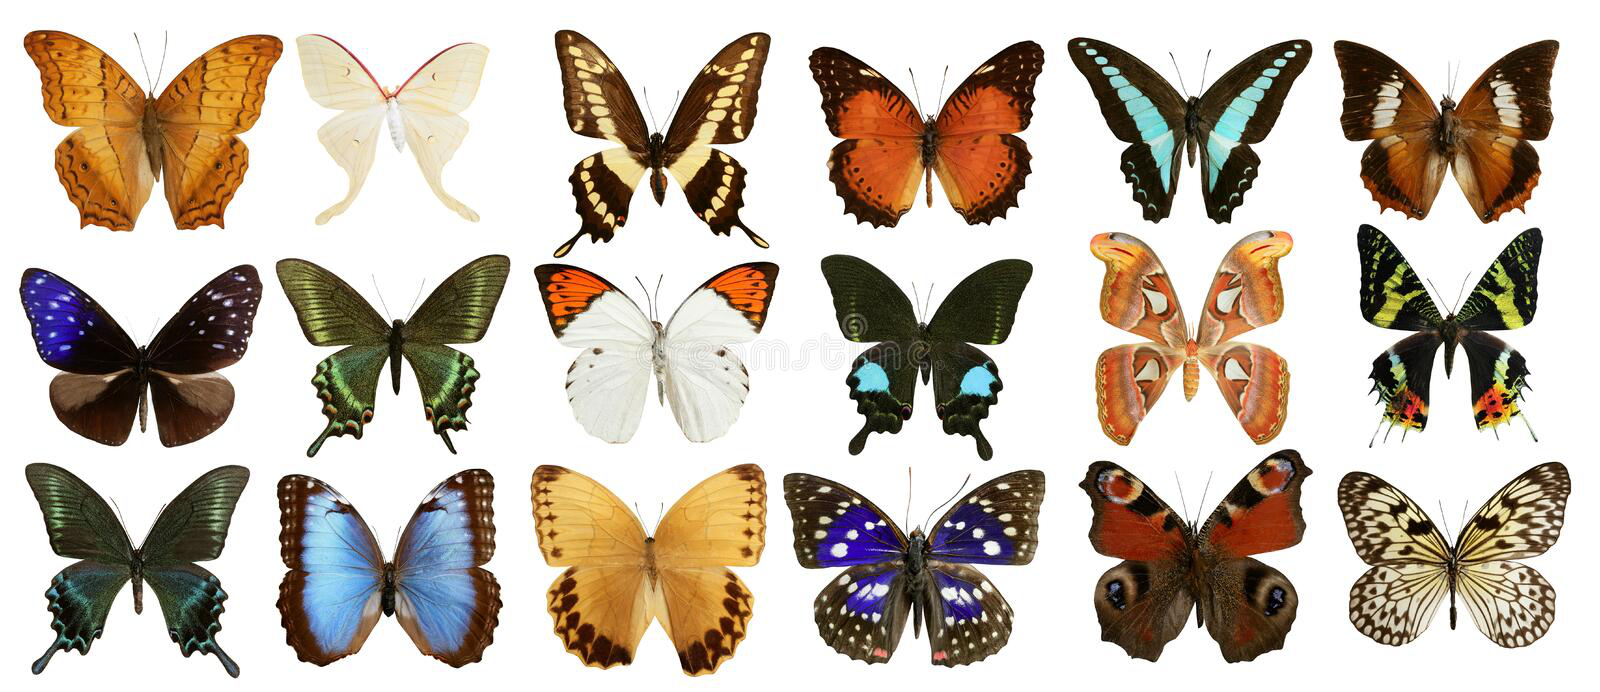

In [121]:
# Download sample image
butterflies = Image.open('butterflies.jpg')
butterflies

In [122]:
from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()
model = model.to(device)

In [123]:
def predict(query, image, score_threshold):

    # Process image and text inputs
    inputs = processor(text=query, images=image, return_tensors="pt").to(device)

    # Set model in evaluation mode
    model.eval()


    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Load example image
    image_size = model.config.vision_config.image_size
    image = mixin.resize(image, image_size)
    input_image = np.asarray(image).astype(np.float32) / 255.0


    # Get prediction logits
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()

    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    
    return input_image, scores, boxes, labels

In [124]:
def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
        if score < score_threshold:
            continue

        cx, cy, w, h = box
        
        ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
                [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
        ax.text(
            cx - w / 2,
            cy + h / 2 + 0.015,
            f"{text_queries[label]}: {score:1.2f}",
            ha="left",
            va="top",
            color="red",
            bbox={
                "facecolor": "white",
                "edgecolor": "red",
                "boxstyle": "square,pad=.3"
            })

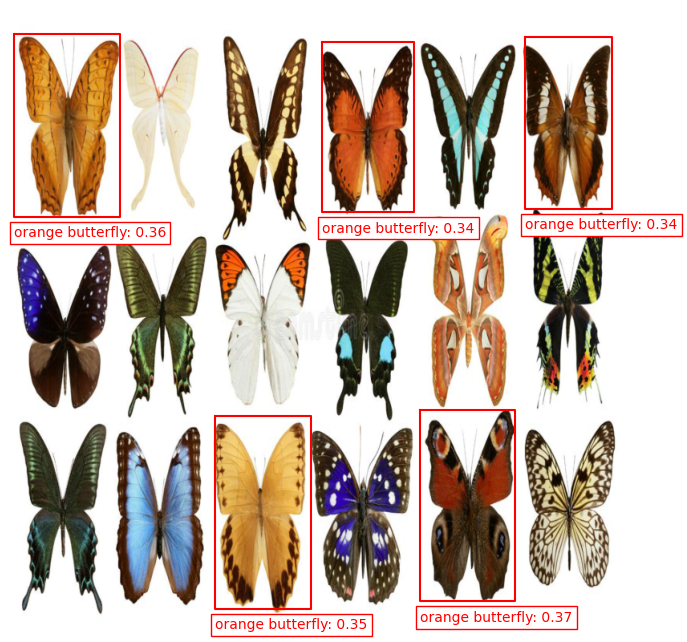

In [125]:
query = ['orange butterfly']

input_image, scores, boxes, labels = predict(query, butterflies, score_threshold=0.32)
plot_predictions(input_image, query, scores, boxes, labels, score_threshold=0.32)

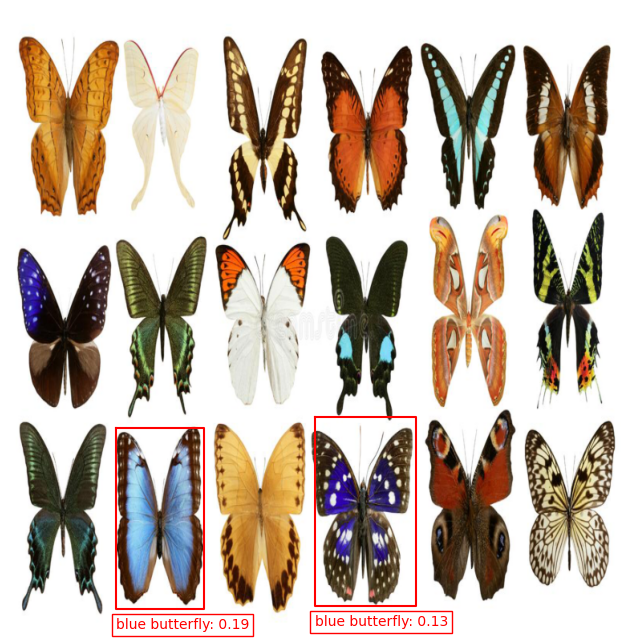

In [15]:
# Text queries to search the image for
query_2 = ['blue butterfly']

input_image, scores, boxes, labels = predict(query_2, butterflies, score_threshold=0.1)
plot_predictions(input_image, query_2, scores, boxes, labels, score_threshold=0.1)

### Как выбрать text prompt, который максимизирует точность детекции объекта?

## Baseline model

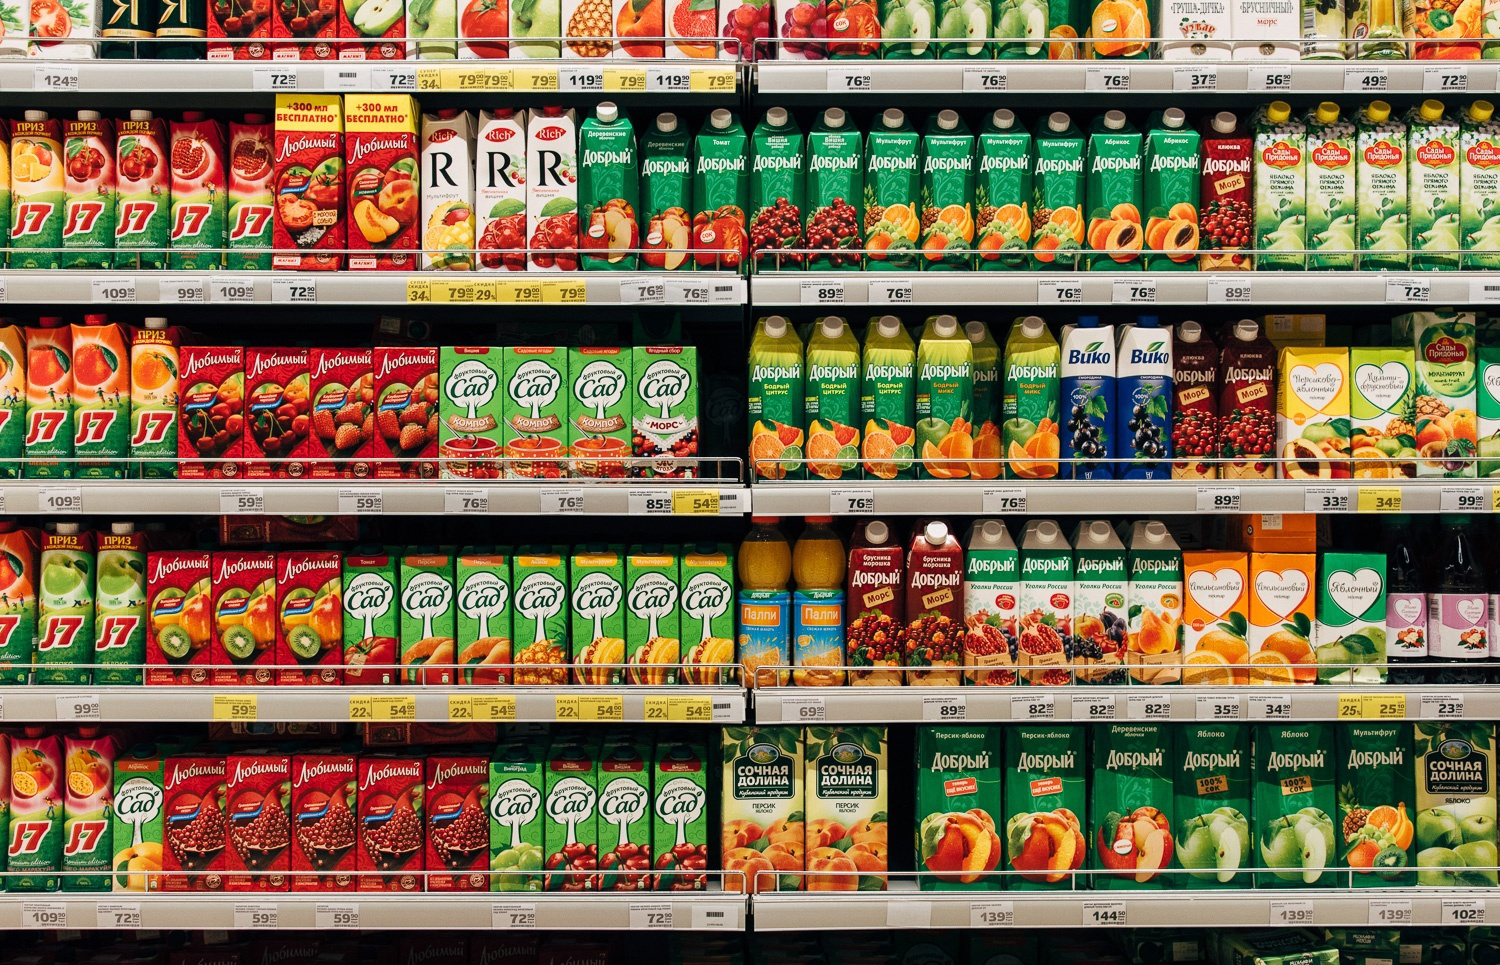

In [16]:
juice = Image.open('juice.jpg')
juice

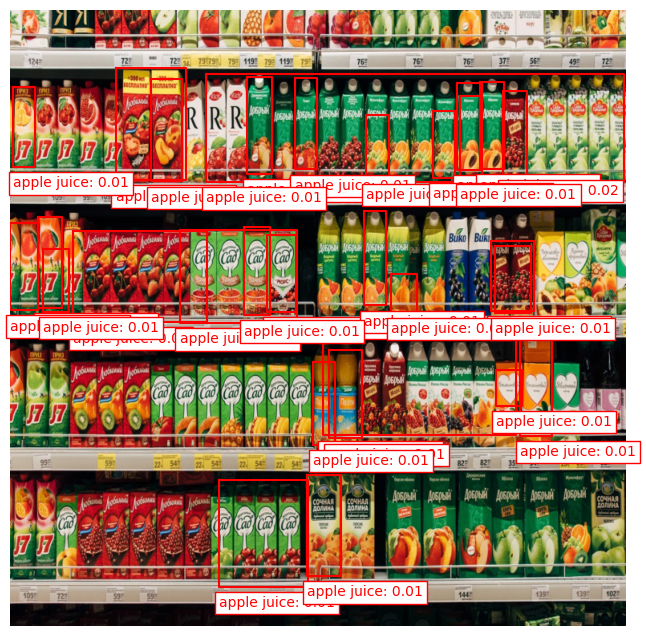

In [17]:
# Text queries to search the image for
query_3 = ['apple juice']

input_image, scores, boxes, labels = predict(query_3, juice, score_threshold=0.01)
plot_predictions(input_image, query_3, scores, boxes, labels, score_threshold=0.01)

### Dataset

In [18]:
annotations = pd.read_csv('./train/_annotations.txt', sep='\t', header=None, names=['boxes'])
classes_annot = pd.read_csv('./train/_classes.txt').values.flatten()

In [34]:
classes_annot = np.array([cls.replace('_', ' ') for cls in classes_annot])

In [35]:
def parsing(x):
    classes = [classes_annot[int(box.split(',')[-1])-1] for box in x]
    boxes = [parse_box(box.split(',')[:-1]) for box in x]
    return classes, boxes

In [36]:
def parse_box(box):
    return [int(b) for b in box]
    

In [37]:
annotations['img'] = annotations.boxes.str.split(' ').apply(lambda x: x[0])
annotations['class'] = annotations['boxes'].str.split(' ').apply(lambda x: parsing(x[1:])).apply(lambda x: x[0])
annotations['boxes'] = annotations['boxes'].str.split(' ').apply(lambda x: parsing(x[1:])).apply(lambda x: x[1])

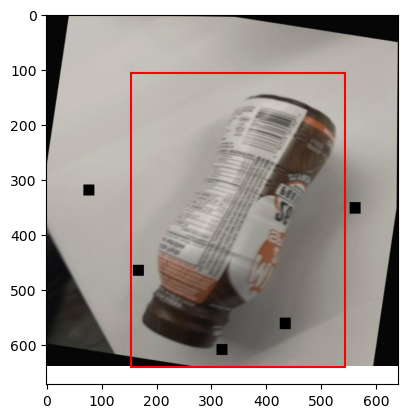

In [38]:
example = plt.imread(os.path.join('./train', annotations.loc[0, 'img']))
plt.imshow(example)
cx, cy, rx, ry = annotations.loc[0, 'boxes'][0]


plt.plot([cx, rx], [cy, cy], c='r')
plt.plot([cx, cx], [cy, ry], c='r')
plt.plot([rx, rx], [cy, ry], c='r')
plt.plot([cx, rx], [ry, ry], c='r')


plt.show()

In [39]:
class VGDataset(Dataset):
    def __init__(self, image_dataset):
        
        self.image_dataset = annotations
        
    def __len__(self):
        return annotations['img'].shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join('./train', self.image_dataset.loc[idx, 'img']))
        boxes = self.image_dataset.loc[idx, 'boxes']
        classes  = self.image_dataset.loc[idx, 'class']
        return image, boxes, classes

In [40]:
val = VGDataset(annotations)

In [41]:
def evaluate(dataset, score_threshold=0.01):
    dataset_iou = []

    
    length = len(dataset)
    dataset = iter(dataset)
        
    for ind in tqdm(range(length)):
        
        image, true_boxes, classes = next(dataset)
        if len(classes) > 0:

            inputs = processor(text=classes, images=image, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model(**inputs)

            target_sizes = torch.Tensor(image.size[::-1]).unsqueeze(0).to(device)
            resized= processor.post_process(outputs=outputs, target_sizes=target_sizes)


            results=[]
            scores_map=[]
            labels_map=[]
            boxes, scores, labels = resized[0]["boxes"], resized[0]["scores"], resized[0]["labels"]
            for box, score, label in zip(boxes, scores, labels):
                box = [round(i, 2) for i in box.tolist()]

                if score >= score_threshold:
                    results.append(box)
                    scores_map.append(score.item())
                    labels_map.append(np.where(classes_annot == classes[label.item()])[0][0])

            box1 = torch.tensor(results, dtype=torch.float)
            box2 = torch.tensor(true_boxes, dtype=torch.float)

            if len(box2) > 0 and len(box1) > 0:
                iou = bops.box_iou(box1, box2)

                image_iou = iou.mean().item()
                dataset_iou.append(image_iou)

    print(f'Average IOU {np.mean(dataset_iou)}')



In [998]:
evaluate(val)

100%|███████████████████████████████████████████████████████████████████████████████| 1521/1521 [02:05<00:00, 12.17it/s]

Average IOU 0.2569961510471425


### Approaches

#### AutoPrompt 
(Shin et al., 2020) proposes taking a gradient-based search (the idea was from Wallace et al., 2019, which aims for searching a universal adversarial trigger to make a model generate a specific prediction) to find out the best prompt for particular tasks.

https://github.com/ucinlp/autoprompt

![autoprompt](autoprompt.png)


Formally, at each step, we compute a first-order approximation of the change in the log-likelihood
that would be produced by swapping the jth trigger token(j) xtrig with another token w ∈ V . Then we identify a candidate set Vcand of the top-k tokens estimated to cause the greatest increase.where win is the input embedding of w, and the gradient is taken with respect to the input embedding of xtrig.

For each candidate in this set, we then re-evaluate Equation (1) on the updated prompt, and retain the prompt with the highest probability in the next step—this requires k forward passes of the model. An example
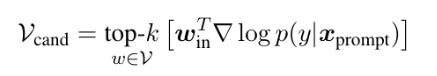
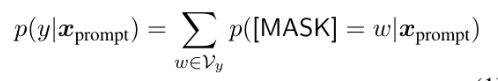

https://docs.yandex.ru/docs/view?tm=1683267885&tld=ru&lang=en&name=2010.15980.pdf&text=AutoPrompt%3A%20Eliciting%20Knowledge%20from%20Language%20Models%20with%20Automatically%20Generated%20Prompts&url=https%3A%2F%2Farxiv.org%2Fpdf%2F2010.15980.pdf&lr=20571&mime=pdf&l10n=ru&sign=b9d6ce39b4b7681501dc1fcc4bbeb8f8&keyno=0&nosw=1&serpParams=tm%3D1683267885%26tld%3Dru%26lang%3Den%26name%3D2010.15980.pdf%26text%3DAutoPrompt%253A%2BEliciting%2BKnowledge%2Bfrom%2BLanguage%2BModels%2Bwith%2BAutomatically%2BGenerated%2BPrompts%26url%3Dhttps%253A%2F%2Farxiv.org%2Fpdf%2F2010.15980.pdf%26lr%3D20571%26mime%3Dpdf%26l10n%3Dru%26sign%3Db9d6ce39b4b7681501dc1fcc4bbeb8f8%26keyno%3D0%26nosw%3D1

In [246]:
val = iter(VGDataset(annotations))

In [251]:
image, bb, classes = next(val)

In [252]:
inputs = processor(text=classes, images=image, return_tensors="pt")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [254]:
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast

TOKENIZER = T5TokenizerFast.from_pretrained("t5-base")
MODEL = T5ForConditionalGeneration.from_pretrained("t5-base")

In [270]:
from itertools import chain
from nltk.corpus import wordnet


cereal


In [292]:
val = iter(VGDataset(annotations))

In [294]:
image, true_boxes, classes = next(val)

print(classes[0])
synonyms = wordnet.synsets(classes[0])
lemmas = ' '.join(set(chain.from_iterable([word.lemma_names() for word in synonyms])))

inputs = processor(text=classes[0]+lemmas, images=image, return_tensors="pt").to(device)

coke


#### Few-shot: 
Gao et al., 2021; Liu et al. (2021) say that instead of randomly sampling some examples, taking in-context demonstrations similar to the query can substantially improve the performance; Lu et al. (2021) show that even the order of the demonstrations matters a lot and propose a way to determine the "optimal" order.

The overall structure is as follows. The relation module is put on the top of the embedding module, which is the part that computes embeddings and class prototypes from input images.

The relation module is fed with the concatenation of the embedding of a query image with each class prototype, and it outputs a relation score for each couple. Applying a Softmax to the relation scores, we get a prediction.

https://openaccess.thecvf.com/content/CVPR2022/papers/Han_Few-Shot_Object_Detection_With_Fully_Cross-Transformer_CVPR_2022_paper.pdf


Qi Fan, Wei Zhuo, Chi-Keung Tang, and Yu-Wing Tai. Fewshot object detection with attention-rpn and multi-relation
detector. In Proceedings of the IEEE/CVF Conference on
Computer Vision and Pattern Recognition, pages 4013–4022,
2020.


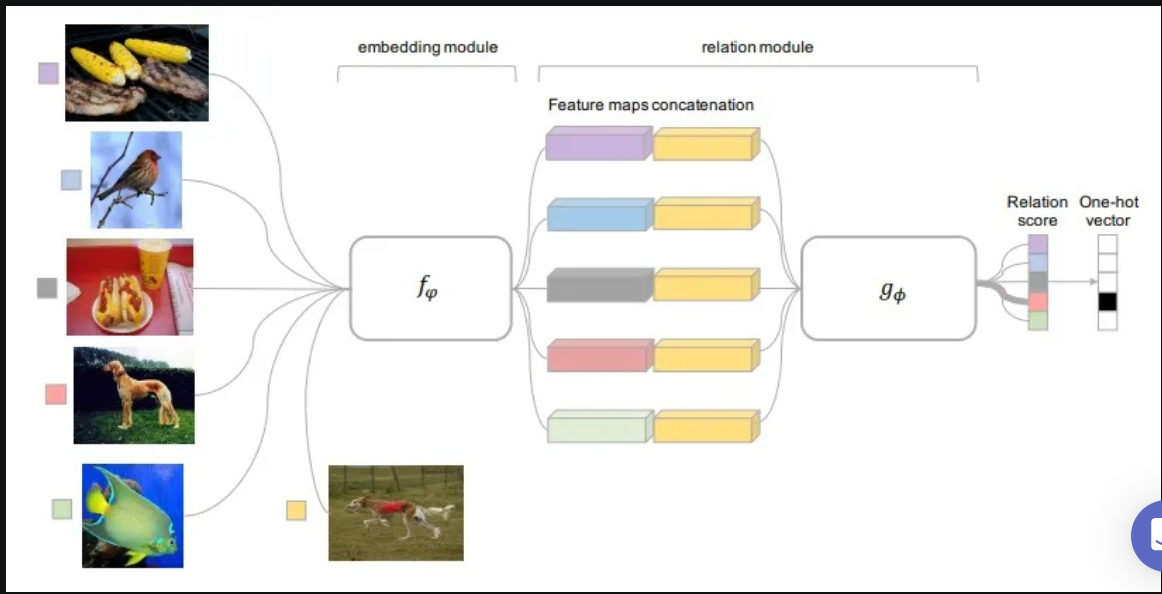


In [910]:
from scipy.spatial import distance

In [773]:
from transformers import BertTokenizer

tz = BertTokenizer.from_pretrained("bert-base-cased")

In [780]:
def tokenize(sent):
    encoded = tz.encode(
        text=sent,
        add_special_tokens=False, 
        max_length = 16, 
        pad_to_max_length=True, 
        return_tensors = 'pt', 
    )

    return encoded[0].numpy()

In [907]:
current_ind = 1
topk=3
data = annotations

In [912]:
def get_few_shot(current_ind, topk=3, data=annotations):
    class_embedding = data['class'].apply(lambda x: tokenize(', '.join(x)))


    current_sample = class_embedding[current_ind]
    curr_embedding = class_embedding[class_embedding.index != current_ind]


    similarity_eq = []
    similarity_cos = []

    for other_sample in curr_embedding:
        if len(other_sample) > 0:
            similarity_eq.append(np.linalg.norm(other_sample - current_sample))
            similarity_cos.append(distance.cosine(other_sample, current_sample))

        else:
            similarity_eq.append(np.nan)
            similarity_cos.append(np.nan)

    similarity_eq = np.array(similarity_eq)
    similarity_cos = np.array(similarity_cos)

    curr_embedding = curr_embedding.reset_index()
    curr_embedding['eq'] = similarity_eq
    curr_embedding['cos'] = similarity_cos

    curr_embedding = curr_embedding.sort_values(by=['eq', 'cos'], ascending=False)
    few_shot_index = curr_embedding[:topk].index
    
    return few_shot_index

In [917]:
get_few_shot(current_ind=1, topk=4)

Int64Index([228, 301, 327, 513], dtype='int64')

### Soft prompts:
putting some random vectors (not tied to specific word embeddings from the vocabulary) in the input sequence and tuning them, with other parts of the pre-trained models fixed using gradient-based search .

In [ ]:
val = VGDataset(annotations)

In [223]:
class Prompt(torch.nn.Module): 
    def __init__(self, input_size, output_size):
        super().__init__()                                
        self.linear1 = torch.nn.Linear(input_size, 32)  
        self.linear2 = torch.nn.Linear(32, output_size) 
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        out = self.relu(self.linear2(self.relu(self.linear1(x))))
        return out.long()

In [224]:
x = torch.empty(16).normal_(mean=1000,std=100)

In [163]:
val = iter(VGDataset(annotations))

In [219]:
image, true_boxes, classes = next(val)
inputs = processor(text=classes, images=image, return_tensors="pt")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [235]:
class PromptVIT(torch.nn.Module): 
    def __init__(self, model, prompt=Prompt(16, 16)):
        super().__init__()                                
        self.prompt = prompt
        self.model = model

    def forward(self, text, inputs):
        inputs['input_ids'] = self.prompt(text).unsqueeze(0)
        out = self.model(**inputs)
        return out

In [238]:
vit = PromptVIT(model)

In [245]:
for name, param in vit.named_parameters():
    if 'model' in name:
        param.requires_grad = False